**<font size="6">Case Study 2: <font size="6">Pneumonia X-Ray Image Analysis**

**Ismail Barkin Ulusoy <br>
Kritameth Coothongkul <br>
Jiwon Lee <br>
Nayoun Kang** <br>

**<br>Last Edited : 1st March 2020<br>**
**<font size="4">Helsinki Metropolia University of Applied Sciences<font size="4">**

**<font size="6">Background**

The objective of this document is to create and try 3 different convolutional neural network models (CNN) that can identify from a collection of chest X-ray image samples if a patient has "pneumonia".

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.<br> Ref: https://www.mayoclinic.org/diseases-conditions/pneumonia/symptoms-causes/syc-20354204

This is in order to help lessen the time doctors need to identify patients who have pneumonia, therefore increasing the amount of patients that can recieve treatment.

Our 3 models will include a basic CNN model, Image data augmentation model, and VGG16 model.

**<font size="6">Data**

Our data (chest x-ray images) are provided by **Daniel Kermany, Kang Zhang and Michael Goldbaum from University of California San Diego** from the following link: https://data.mendeley.com/datasets/rscbjbr9sj/2 <br> 

The original dataset includes 5,859 chest X-ray images.<br> The images are split into 2 folders named "training" and "test" with 2 subfolders for each called "PNEUMONIA" and "NORMAL".

In [1]:
%pylab inline
import time
import os
import shutil
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, FalseNegatives, FalsePositives, SensitivityAtSpecificity
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

Populating the interactive namespace from numpy and matplotlib


We split the datasets into 3 different subsets which are<br>
60% training<br> 
20% validation<br>
20% test<br>
This was provided to us by our classmate "Simo Mäkelä" from the following link: https://www.kaggle.com/simomake/chest-xray-images-for-classification-pneumonia

## Training Files

In [2]:
#Training files can be found here.
train_dir = 'C:/Users/Marker/Desktop/chest-xray/pneumonia2/train'

In [3]:
train_normal_images = [x for x in os.listdir(os.path.join(train_dir,'NORMAL')) if x.endswith(".jpeg")]
train_pneumonia_images = [x for x in os.listdir(os.path.join(train_dir,'PNEUMONIA')) if x.endswith(".jpeg")]

In [4]:
T_NORMAL = len(train_normal_images)
T_PNEUMONIA = len(train_pneumonia_images)
TOTAL = T_NORMAL + T_PNEUMONIA

print('Training Images:')
print(f'{T_NORMAL:5d} normal cases')
print(f'{T_PNEUMONIA:5d} pneumonia cases')
print(f'{TOTAL:5d} totally.')

Training Images:
  949 normal cases
 2564 pneumonia cases
 3513 totally.


## Test Files

In [5]:
#Test files are manualy added 
test_dir = 'C:/Users/Marker/Desktop/chest-xray/pneumonia2/test'

In [6]:
test_normal_images = [x for x in os.listdir(os.path.join(test_dir,'NORMAL')) if x.endswith(".jpeg")]
test_pneumonia_images = [x for x in os.listdir(os.path.join(test_dir,'PNEUMONIA')) if x.endswith(".jpeg")]

In [7]:
TE_NORMAL = len(test_normal_images)
TE_PNEUMONIA = len(test_pneumonia_images)
TE_TOTAL = TE_NORMAL + TE_PNEUMONIA

print('Test Images:')
print(f'{TE_NORMAL:5d} normal cases')
print(f'{TE_PNEUMONIA:5d} pneumonia cases')
print(f'{TE_TOTAL:5d} totally.')

Test Images:
  317 normal cases
  854 pneumonia cases
 1171 totally.


## Validation Files

In [8]:
#Validation files can be found here
val_dir = 'C:/Users/Marker/Desktop/chest-xray/pneumonia2/validation'

In [9]:
test_normal_images = [x for x in os.listdir(os.path.join(val_dir,'NORMAL')) if x.endswith(".jpeg")]
test_pneumonia_images = [x for x in os.listdir(os.path.join(val_dir,'PNEUMONIA')) if x.endswith(".jpeg")]

In [10]:
VAL_NORMAL = len(test_normal_images)
VAL_PNEUMONIA = len(test_pneumonia_images)
VAL_TOTAL = VAL_NORMAL + VAL_PNEUMONIA

print('Validation Images:')
print(f'{VAL_NORMAL:5d} normal cases')
print(f'{VAL_PNEUMONIA:5d} pneumonia cases')
print(f'{VAL_TOTAL:5d} totally.')

Validation Images:
  317 normal cases
  855 pneumonia cases
 1172 totally.


## Data Generator

As the image data files were too big, the time needed for training each CNN would have taken too long therefore we rescaled the image size range down from [255,0] to [1,0].<br>
We also create 3 different generators for each of the subset folders.<br>
The class mode were binary as to identify between "PNEUMONIA" and "NORMAL"

In [11]:
print('Training:')
TS = (150, 150)
BS = 128

#Training data generator
tg = ImageDataGenerator(rescale=1./255)
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary')

#Validation data generator
print('Validation:')
devg = ImageDataGenerator(rescale=1./255)
dev_generator = devg.flow_from_directory(
    val_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode = 'binary')

#Testing data generator
print('Testing:')
testg = ImageDataGenerator(rescale=1./255)
test_generator = testg.flow_from_directory(
    test_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode = 'binary')

Training:
Found 3513 images belonging to 2 classes.
Validation:
Found 1172 images belonging to 2 classes.
Testing:
Found 1171 images belonging to 2 classes.


## CNN Model 1

For the basic CNN model we used the following link: https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7
as a guide for us to choose the number of epochs needed and the general filter size to use. We've tried filter size of 3x3, 5x5, and 7x7 but according to our results 5x5 was the best filter. As for the epochs we......<br>
We have also tried from Conv2D-MaxPooling2D to Conv2D-Conv2D-MaxPooling2D however Conv2D-MaxPooling2D came out with better results.

In [12]:
#Create the main model to train the data
model = models.Sequential()

model.add(layers.Conv2D(32, (5, 5), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (5, 5), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

#Specify the metrics
Met = [ SensitivityAtSpecificity(0.9), 'acc', FalsePositives(), FalseNegatives(),]

#Compile the model
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = Met)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        2

In [13]:
#Select number of epochs
E = 32

#Start the timer
t_start = time.time()

#Start the training
history = model.fit_generator(
      train_generator,
      steps_per_epoch = None, # = 3365//16
      verbose = 0,
      epochs = E,
      validation_data = dev_generator,
      validation_steps = None # = 1441//16
      )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [14]:
#End timer and print the total time
t_end  = time.time()
t_elapsed = t_end - t_start
t_per_epoch = t_elapsed/e
print('Total time elapsed(s):')
print(t_elapsed)
print('Time per epoch(s):')
print(t_per_epoch)

Total time elapsed(s):
1335.833253145218
Time per epoch(s):
491.42559066529265


In [15]:
# Find the labels
labels = dev_generator.classes

# Predict the resulsts
predicted = model.predict_generator(dev_generator).flatten()

Instructions for updating:
Please use Model.predict, which supports generators.


In [16]:
#Create the Confusion matrix
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels, predicted > 0.5)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels, predicted > 0.5).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn],[fp, tn]]))

Confusion matrix (machine learning way):
[[265  52]
 [ 34 821]]
Confusion matrix (medicine way):
[[821  34]
 [ 52 265]]


In [17]:
#Calculate the classification report
cr = classification_report(labels, predicted > 0.5, target_names = ['Normal(0)', 'Pneumonia(1)'])
print(cr)

              precision    recall  f1-score   support

   Normal(0)       0.89      0.84      0.86       317
Pneumonia(1)       0.94      0.96      0.95       855

    accuracy                           0.93      1172
   macro avg       0.91      0.90      0.91      1172
weighted avg       0.93      0.93      0.93      1172



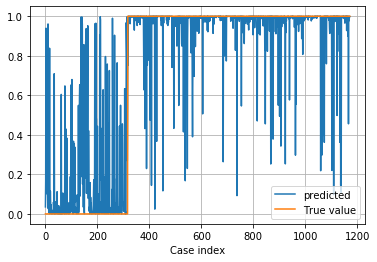

In [18]:
#Plot the predicted and true labels as lists
plot(predicted,  label = 'predicted')
plot(labels, label= 'True value')
legend()
xlabel('Case index')
grid()

In [19]:
#Variable assignment for ploting the graphs
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
false_positives = history.history['false_positives']
val_false_positives = history.history['val_false_positives']
false_negatives = history.history['false_negatives']
val_false_negatives = history.history['val_false_negatives']
sens_spec = history.history['sensitivity_at_specificity']
val_sens_spec = history.history['val_sensitivity_at_specificity']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

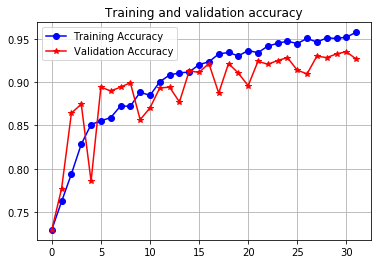

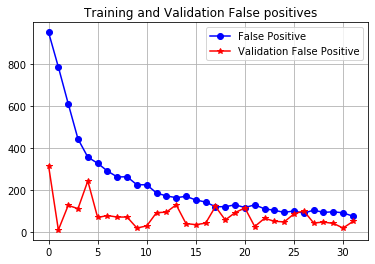

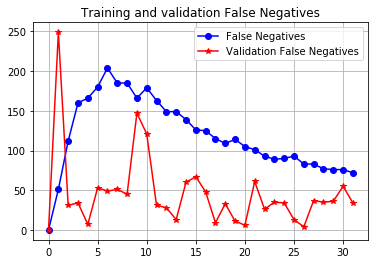

In [20]:
#Accuracy comparison plot
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.grid()
plt.legend()

#False positive comparison plot
plt.figure()
plt.plot(epochs, false_positives, 'bo-', label='False Positive')
plt.plot(epochs, val_false_positives, 'r*-', label='Validation False Positive')
plt.title('Training and Validation False positives')
plt.legend()
plt.grid()

#False negative comparison plot
plt.figure()
plt.plot(epochs, false_negatives, 'bo-', label='False Negatives')
plt.plot(epochs, val_false_negatives, 'r*-', label='Validation False Negatives')
plt.title('Training and validation False Negatives')
plt.legend()
plt.grid()

plt.show()

From the graphs the training and validation accuracy looks good as it goes up over time.<br>
The training of False positives goes down over time which is good,as for the validation it has some spikes in it but it still relatively goes down therefore it is ok.<br>
The training of False negatives goes down over time, however the validation goes up after 16 epochs which is not good.

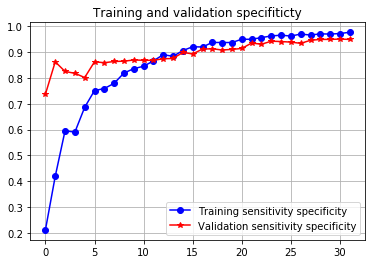

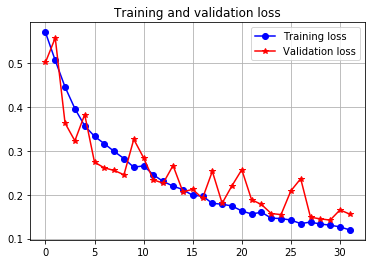

In [21]:
#Sensitivity specificity comparison plot
plt.plot(epochs, sens_spec, 'bo-', label='Training sensitivity specificity')
plt.plot(epochs, val_sens_spec, 'r*-', label='Validation sensitivity specificity')
plt.title('Training and validation specifiticty')
plt.grid()
plt.legend()

#Loss comparison plot
plt.figure()
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

Training and validation of specificity looks good as it goes up over time.<br>
Training and validation of loss also looks good as they go down over time.

In [22]:
#Roc Curve variables
fpr, tpr, thresholds = roc_curve(labels, predicted, pos_label = 1)

The Roc curve looks good as it is close to 1

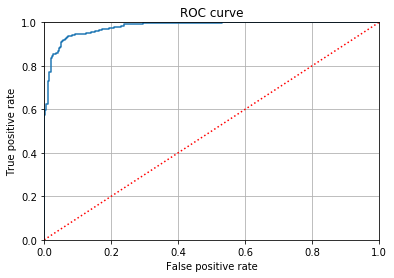

In [23]:
#Roc Curve plot
plot(fpr, tpr)
plot([0,1], [0,1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

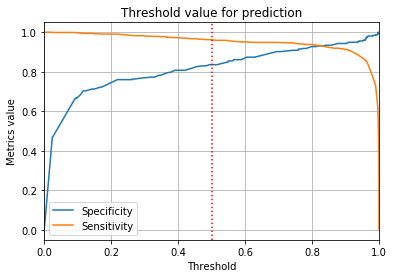

In [24]:
#Find best threshold for the settings
plot(thresholds, 1 -fpr, label = 'Specificity')
plot(thresholds, tpr, label = 'Sensitivity')
axvline(0.5, color ='red', linestyle = ':')
xlim([0,1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

 From this graph you can see that the best threshold for this model is 0.80-0.85

## Data Augmentation Model

The second model we tried was the Data Augementation Model which is very similar to the first model<br>
Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks.<br>

In [25]:
#Select Target size and Batch size of data
TS = (150, 150)
BS = 128

#Only Augment the training data
tg = ImageDataGenerator( rescale=1./255,
                        rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2, zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode='nearest')
#Generator the training data
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary')

Found 3513 images belonging to 2 classes.


In [26]:
#Compile The model
Met = [ SensitivityAtSpecificity(0.9), 'acc', FalsePositives(), FalseNegatives()]

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-4),
              metrics = Met)

In [27]:
#Select the epochs
E = 32

#Start the timer
t_start = time.time()

#Train the data using the Network in Model 1
history = model.fit_generator(
      train_generator,
      steps_per_epoch = None, # = 3365//16
      verbose = 0,
      epochs = E,
      validation_data = dev_generator,
      validation_steps = None # = 1441//16
      )

  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [28]:
#End timer and print the total time
t_end  = time.time()
t_elapsed = t_end - t_start
t_per_epoch = t_elapsed/e
print('Total time elapsed(s):')
print(t_elapsed)
print('Time per epoch(s):')
print(t_per_epoch)

Total time elapsed(s):
1833.0412476062775
Time per epoch(s):
674.3381898136008


In [29]:
# Find the labels
labels = dev_generator.classes

# Predict the resulsts
predicted = model.predict_generator(dev_generator).flatten()

In [30]:
#Create the Confusion matrix
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels, predicted > 0.5)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels, predicted > 0.5).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn],[fp, tn]]))

Confusion matrix (machine learning way):
[[ 86 231]
 [  1 854]]
Confusion matrix (medicine way):
[[854   1]
 [231  86]]


In [31]:
#Calculate the classification report
cr = classification_report(labels, predicted > 0.5, target_names = ['Normal(0)', 'Pneumonia(1)'])
print(cr)

              precision    recall  f1-score   support

   Normal(0)       0.99      0.27      0.43       317
Pneumonia(1)       0.79      1.00      0.88       855

    accuracy                           0.80      1172
   macro avg       0.89      0.64      0.65      1172
weighted avg       0.84      0.80      0.76      1172



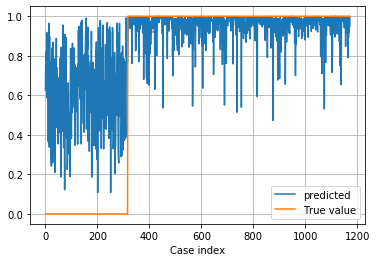

In [32]:
#Plot the predicted and true labels as lists
plot(predicted,  label = 'predicted')
plot(labels, label= 'True value')
legend()
xlabel('Case index')
grid()

In [33]:
#Variable assignment for ploting the graphs
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
false_positives = history.history['false_positives_1']
val_false_positives = history.history['val_false_positives_1']
false_negatives = history.history['false_negatives_1']
val_false_negatives = history.history['val_false_negatives_1']
sens_spec = history.history['sensitivity_at_specificity_1']
val_sens_spec = history.history['val_sensitivity_at_specificity_1']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

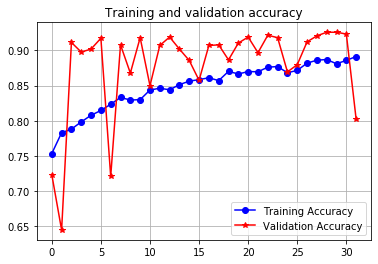

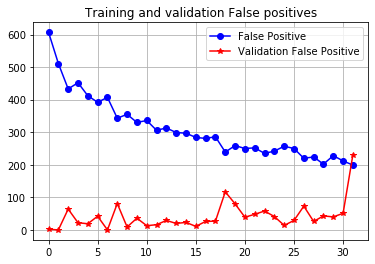

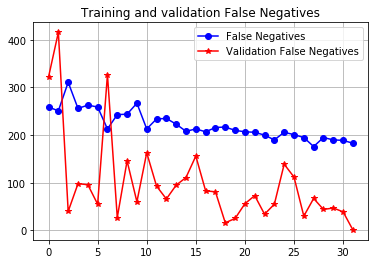

In [34]:
#Accuracy comparison plot
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r*-', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.grid()
plt.legend()

#False positive comparison plot
plt.figure()
plt.plot(epochs, false_positives, 'bo-', label='False Positive')
plt.plot(epochs, val_false_positives, 'r*-', label='Validation False Positive')
plt.title('Training and validation False positives')
plt.legend()
plt.grid()

#False negative comparison plot
plt.figure()
plt.plot(epochs, false_negatives, 'bo-', label='False Negatives')
plt.plot(epochs, val_false_negatives, 'r*-', label='Validation False Negatives')
plt.title('Training and validation False Negatives')
plt.legend()
plt.grid()

plt.show()

Although the training accuracy looks good as it goes up, the validation looks really bad accuracy as it is too unstable and cannot be comprehended if is going down at all.<br>
The training and validation of False positives also don't look good because the training goes down but not alot and the validation does not seem to go up or down over time.<br>
The training and validation of False negatives also seem too unstable to be used.

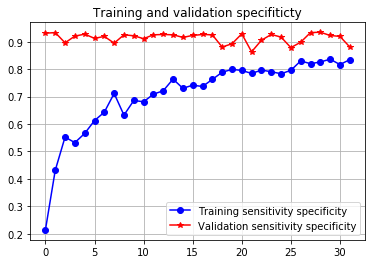

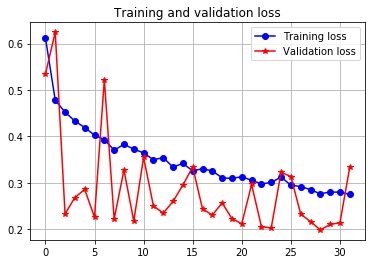

In [35]:
#Sensitivity Specificity plot
plt.plot(epochs, sens_spec, 'bo-', label='Training sensitivity specificity')
plt.plot(epochs, val_sens_spec, 'r*-', label='Validation sensitivity specificity')
plt.title('Training and validation specifiticty')
plt.grid()
plt.legend()

#Loss comparison plot
plt.figure()
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r*-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.grid()

plt.show()

Training for specificity looks fine as it goes up over time however validation does not seem to change therefore not great.
Training for loss also looks fine as it goes down over time however validation is just too unstable once again.

In [36]:
#Variables for Roc Curve
fpr, tpr, thresholds = roc_curve(labels, predicted, pos_label = 1)

The ROC curve however looks ok

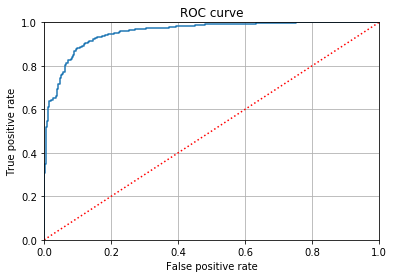

In [37]:
#Roc Curve plot
plot(fpr, tpr)
plot([0,1], [0,1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

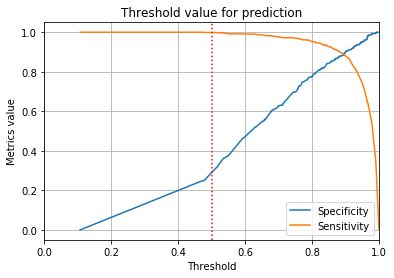

In [38]:
#Finding the best threshold for the model
plot(thresholds, 1 -fpr, label = 'Specificity')
plot(thresholds, tpr, label = 'Sensitivity')
axvline(0.5, color ='red', linestyle = ':')
xlim([0,1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

 The best threshold for this model is around 0.85-0.90

## VGG16 Model

For the third model we imported the pretrained model from Github: https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3<br> A pretrained model from VGG16 which is a convolution neural net (CNN ) architecture which was used to win ILSVR(Imagenet) competition in 2014.<br>
Ref:' https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c '<br>
However the code for extracting the features was given to us by Professor 'Juha Kopu' from the oma system (Lecture 12: Data augmentation and pretrained CNNs.pdf) 

In [39]:
#Import VGG16 and download the data for it.
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False,
input_shape=(150,150,3))
conv_base.summary()

Using TensorFlow backend.


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [40]:
#Reset data generator from previous model for training
tg = ImageDataGenerator(rescale=1./255)
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary')

#Reset data generator from previous model for training
testg = ImageDataGenerator(rescale=1./255)
test_generator = testg.flow_from_directory(
    test_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode = 'binary')

Found 3513 images belonging to 2 classes.
Found 1171 images belonging to 2 classes.


In [41]:
#Extract the features from the data to be able to train using VGG16
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
#Seperate the Features from the Labels
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) 
    labels = np.zeros(shape=(sample_count)) 
    generator = datagen.flow_from_directory( directory, target_size=(150,150), batch_size=batch_size, class_mode='binary') 
    i = 0 
    # Create features batches to be able to extract the training and validation features and their labels.
    for inputs_batch, labels_batch in generator: 
        features_batch = conv_base.predict(inputs_batch) 
        features[i*batch_size:(i+1)*batch_size] = features_batch 
        labels[i*batch_size:(i+1)*batch_size] = labels_batch 
        i += 1 
        if i*batch_size >= sample_count:
            break 
    #Return the features and labels seperately
    return features, labels

#Divide and extract the labels and features from the Training directory and Validation directory which hold the data
train_features, train_labels = extract_features(train_dir, 1000)
validation_features, validation_labels = extract_features(val_dir, 500)

Found 3513 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [42]:
#Create the model and add layers
model = models.Sequential()

#Flatten the input to fit the shape
model.add(layers.Flatten(input_shape=(4, 4, 512)))
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [43]:
#Set the metrics for training
Met = [ SensitivityAtSpecificity(0.9), 'acc', FalsePositives(), FalseNegatives()]

#Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr = 1e-4),
              metrics = Met
             )

We could not find a way to add the validation data into this model

In [44]:
#Select epochs
E = 32

#Start training the model
history = model.fit(train_features,
                    train_labels,
                    steps_per_epoch = None,
                    verbose = 0,
                    epochs = E,
                    use_multiprocessing = True,
            )

In [45]:
#Variable assignment for ploting the graphs
accuracy = history.history['acc']
false_positives = history.history['false_positives_2']
false_negatives = history.history['false_negatives_2']
sens_spec = history.history['sensitivity_at_specificity_2']
loss = history.history['loss']
epochs = range(len(accuracy))

We only have the main data because we couldnt add the validation data so we could not compare them.

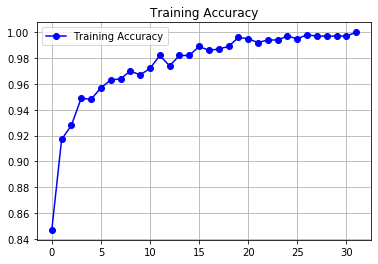

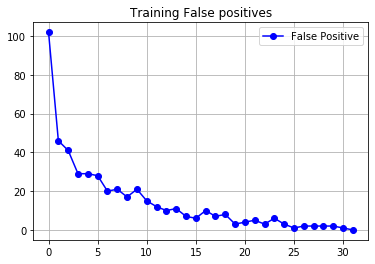

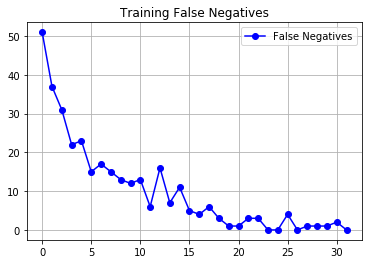

In [46]:
#Accuracy Graph
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.grid()
plt.legend()

#False positive Graph
plt.figure()
plt.plot(epochs, false_positives, 'bo-', label='False Positive')
plt.title('Training False positives')
plt.legend()
plt.grid()

#False negative Graph
plt.figure()
plt.plot(epochs, false_negatives, 'bo-', label='False Negatives')
plt.title('Training False Negatives')
plt.legend()
plt.grid()

plt.show()

Although we could not find a way to add in validation data, the graphs looks good as training accuracy goes up overtime and false negatives and false positives goes down overtime.

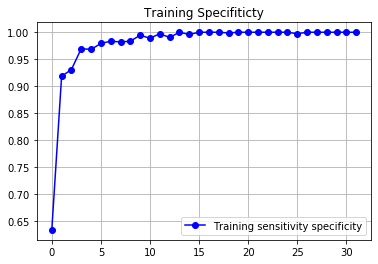

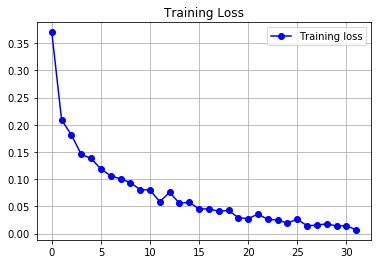

In [47]:
#Sensitivity Specificity graph
plt.plot(epochs, sens_spec, 'bo-', label='Training sensitivity specificity')
plt.title('Training Specifiticty')
plt.grid()
plt.legend()

#Loss graph
plt.figure()
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.title('Training Loss')
plt.legend()
plt.grid()

plt.show()

Training Specificity looks good as they go up over time.
Training loss looks good as they go down over time

## Conclusion And Review

In model 1 we started by testing the starter model which was very basic and had 4 Conv2D and 4 MaxPooling. The results were quite good but we decided to try different setups to see how the model would react.
  
While conducting these researches we used the Gpu computation since it cut our training by half time.  
  
We tested with high epochs but figured out that after around 60 epochs it takes a very long time to compute and the data tends to overfit for us.  
  
We got errors when playing with the MaxPool size and Conv2D size, and we learned that they had to match in a certain way to the data to be able to use. For example not using 7x7 Conv2D and 3x3 MaxPooling.  

Model 2 compared to model 1 is pretty bad result wise. The biggest difference we see in the graphs are that the false positives start on complete different ends of the graph which is because of the Data Augmentation and changes in the training data. Model 2 has 84% Average accuracy where Model 1 has 94% in defining if someone is sick.Model 2 also has very low F1 scores and bad scores overall.  
  
Model 2 also takes around 500 seconds longer than Model 1.  
  
General time wise from longest to shortest : Model 2 > Model 1 > Model 3
   
Model 2, when looked at Confusion Matrix the scores seem fine but when we look at the graphs we see that its unreliable since there are too many random jumps in the graph. This would not be good in a real life situation regarding health which will determine if someone has pneunomia or not.  
  
Model 3(VGG16) compared to Model 1 seems more stable when we look at the Training values. Model 1 has a slower increase in accuracy where Model 3 has a stable and high velocity increase in learning. Since we could not implement the Validation data we could not compare it to the training learning rate. From the graphs alone we could assume using Model 3 would be better since it reduces the training time more than 99% and still has good feedbacks on the graphs.  
  
If we have to conclude we would go for Model 3 even tough Model 1 was great too but Model 2 was really unstable and not that good at differentiating the data.
